In [13]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

In [14]:
# specify experiment date
log_date = '06-11-2023'
log_name = ''

In [15]:
# compute log directory, params, etc
log_dir = os.path.join('data', log_date + '_' + log_name)

with open(os.path.join(log_dir, 'params.json'), 'r') as handle:
    params = json.load(handle)

# reconstruct the dataframe
all_d_frames = []
for d in params['ds']:
    all_d_frames.append(pd.read_pickle(os.path.join(log_dir, 'prm_%s_d%i.pkl' % (log_date, d))))

all_ds_df = pd.concat(all_d_frames, axis=1, keys=params['ds'], names=['dimension', 'n samples'])

In [16]:
# first, take floor so non-perfect trials are zeroes out
all_ds_df_floored = all_ds_df.apply(np.floor)

# now sum across trials, divide for prob estimate
all_ds_df_likelihoods = all_ds_df_floored.sum(axis=0).divide(params['n_trials']).to_frame().transpose()

all_ds_df_likelihoods

dimension      2                                  4                       \
n samples 10     100    1000   10000  100000 10     100    1000   10000    
0            0.5    1.0    1.0    0.5    0.5    0.0    0.0    0.0    0.0   

dimension             6                              
n samples 100000 10     100    1000   10000  100000  
0            0.0    0.0    0.0    0.0    0.0    0.0

In [17]:
all_ds_df_likelihoods.melt()

,dimension,n samples,value
0,2,10,0.5
1,2,100,1.0
2,2,1000,1.0
3,2,10000,0.5
4,2,100000,0.5
5,4,10,0.0
6,4,100,0.0
7,4,1000,0.0
8,4,10000,0.0
9,4,100000,0.0


In [18]:
# compute the probability the bound would give and load into dataframe
def vol_unit_d_ball(d):
    return math.pow(math.pi, float(d) / 2) / math.gamma(float(d / 2) + 1)

def compute_failure_prob_from_sample(m, tol, d):
    alpha = tol / math.sqrt(1 + tol * tol)
    exponent =  m * math.pow(alpha, d) * vol_unit_d_ball(d) / 4
    return 2 / np.exp(exponent)

ms = np.array(params['sample_schedule'])
success_probs = []
for d in params['ds']:
    success_prob = 1 - compute_failure_prob_from_sample(ms, params['tol'], d)
    success_probs.append(success_prob)

mc = pd.MultiIndex.from_product([params['ds'], params['sample_schedule']],
                                names=['dimension', 'n samples'])
theoretical_likelihood_bound = pd.DataFrame(np.concatenate(success_probs).reshape(1, -1), columns=mc)

/tmp/ipykernel_732815/1707483540.py:8: RuntimeWarning: overflow encountered in exp
  return 2 / np.exp(exponent)


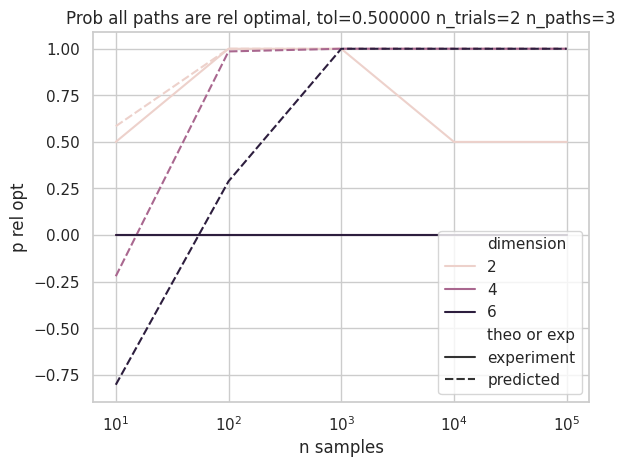

In [20]:
bound_and_experiment_df = pd.concat(
    [all_ds_df_likelihoods, theoretical_likelihood_bound],
    axis=1,
    keys=['experiment', 'predicted'],
    names=['theo or exp']
)

# melt the data into long form, plot on seaborn
likelihoods_long_form = bound_and_experiment_df.melt(value_name='p rel opt')

plt.figure()
sns.set_theme(style='whitegrid')
sns.lineplot(x='n samples', y='p rel opt', hue='dimension', style='theo or exp', data=likelihoods_long_form)
plt.xscale('log')
plt.legend(loc='lower right')
plt.title('Prob all paths are rel optimal, tol=%f n_trials=%i n_paths=%i' % (params['tol'], params['n_trials'], params['n_paths']))

# compute the result the bound would give
plt.show()
